In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import warnings, os
from typing import Union
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold

os.makedirs('preds/', exist_ok=True)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# loading datasets
train_gap = pd.read_csv('data/Gap_Train.csv')
test_gap = pd.read_csv('data/Gap_Test.csv')
train = pd.read_parquet('data/train_preprocessed.parquet')
test = pd.read_parquet('data/test_preprocessed.parquet')

In [3]:
# target variables
target_variables = train.loc[:, 'N':'B'].columns.tolist()

# selected features
selected_features = train.columns.drop(['PID', 'site', 'lat', 'lon', 'mb1', 'mb2', 'mb3', 'mb7']+target_variables) # , 'lat', 'lon'

print('Number of selected features: ', len(selected_features))

Number of selected features:  203


In [4]:
# scaler
scaler = MinMaxScaler()

# For reproducibility
seed = 483

# transformer
transform_type = None

In [5]:
def transform_predictions(preds, transform_type):
    """
    Transforms target predictions to original values
    """
    if transform_type == 'sqrt':
        preds = np.square(preds)
    elif transform_type == 'log1p':
        preds = np.expm1(preds)
    elif callable(transform_type):
        preds = transform_type(preds)
    return preds

def eval_metrics(y_actual, y_preds, transform=None):
    y_actual = transform_predictions(y_actual, transform)
    y_preds = transform_predictions(y_preds, transform)
    rmse = root_mean_squared_error(y_actual, y_preds)
    r2 = r2_score(y_actual, y_preds)
    mse = np.square(rmse)
    mae = mean_absolute_error(y_actual, y_preds)
    res = pd.DataFrame({
        'RMSE':[rmse], 'MAE':[mae], 'MSE':[mse], 'R2':[r2]
    }, index=['scores'])
    return res

In [6]:
def calculate_regression_eval_metrics(model, X, y, target_scaled=False, transform=None,
                                      return_individual_result=False):
    results = []
    y_preds = scaler.inverse_transform(model.predict(X)) if target_scaled else model.predict(X)
    y_actual = scaler.inverse_transform(y) if target_scaled else y

    if not return_individual_result:
        return eval_metrics(y_actual, y_preds, transform)
    else:
        for i, col in enumerate(target_variables):
            res = eval_metrics(y_actual[:, i], y_preds[:, i], transform)
            res.index = [col]
            results.append(res)
        return pd.concat(results, axis=0).round(3)

In [7]:
def get_feature_importances(model):
    if model.__class__.__name__ == 'MultiOutputRegressor':
        model_imp = pd.DataFrame(
            np.column_stack(
                list(
                    map(lambda x: x.feature_importances_, model.estimators_))
                ), columns=target_variables, index=selected_features)
    else:
        model_imp = pd.Series(model.feature_importances_, index=selected_features)
    return model_imp.transform(lambda x: x/x.sum())


def plot_feature_importance(df, nrow, ncol, topn=20, figsize=(15,15)):
    fig = plt.figure(figsize=figsize)
    i = 0
    if isinstance(df, pd.DataFrame):
        for col in tqdm(target_variables):
            plt.subplot(nrow, ncol, i+1)
            df.loc[:, col].nlargest(topn)[::-1].plot.barh(fontsize=8)
            plt.title(col, fontsize=9)
            i += 1
    else:
        df.nlargest(topn)[::-1].plot.barh(fontsize=8)
    plt.tight_layout()
    plt.suptitle('Feature Importances', y=1.01, fontweight='bold');

In [8]:
def eval_metrics_gap(model, X, y, gap_df, target_scaled=False, transform_type=None, return_individual_results=True):
    idx_vals = X.index.tolist()
    X_gap = gap_df.copy()
    PIDs = train.iloc[idx_vals][['PID', 'BulkDensity']]
    # y_copy = y.copy().reset_index(drop=True)
    predictions = model.predict(X)
    if target_scaled:
        predictions = scaler.inverse_transform(predictions)

    # transform predictions back to original values
    predictions = transform_predictions(predictions, transform_type)
    predictions = pd.DataFrame(predictions, columns=target_variables, index=idx_vals)

    preds_df = pd.concat([PIDs, predictions], axis=1)
    preds_df = pd.melt(preds_df, id_vars=['PID', 'BulkDensity'], var_name='Nutrient', value_name='Available_pred_in_ppm')
    preds_df = pd.merge(preds_df, X_gap, on=['Nutrient', 'PID'])

    soil_depth = 20  # cm

    # Calculate the Available_Nutrients_in_kg_ha
    preds_df['Available_pred_in_kg_ha'] = (preds_df['Available_pred_in_ppm'] * soil_depth * preds_df['BulkDensity'] * 0.1)
    preds_df["Gap_pred"] = preds_df["Required"] - preds_df["Available_pred_in_kg_ha"]

    rmse = root_mean_squared_error(preds_df['Gap'], preds_df['Gap_pred'])
    mae = mean_absolute_error(preds_df['Gap'], preds_df['Gap_pred'])
    if return_individual_results:
        print(f'RMSE: {rmse:.5f}\tMAE: {mae:.5f}\n')
        # print for all
        eval_results = pd.DataFrame(columns=['Nutrient', 'RMSE', 'MAE'])
        for col in target_variables:
            res = preds_df.query(f'Nutrient == "{col}"')[['Gap', 'Gap_pred']]
            rmse = root_mean_squared_error(res['Gap'], res['Gap_pred'])
            mae = mean_absolute_error(res['Gap'], res['Gap_pred'])
            eval_results = pd.concat([eval_results, pd.DataFrame([[col, rmse, mae]], columns=['Nutrient', 'RMSE', 'MAE'])])
        return eval_results.set_index('Nutrient').T
    else:
        return pd.DataFrame({'RMSE':[rmse], 'MAE': [mae]})

In [9]:
def create_predictions_table(model_predictions, gap_df):
    X_gap = gap_df.copy()
    PIDs = test[['PID', 'BulkDensity']].reset_index(drop=True)
    # y_copy = y.copy().reset_index(drop=True)
    predictions = pd.DataFrame(model_predictions, columns=target_variables)
    preds_df = pd.concat([PIDs, predictions], axis=1)

    preds_df = pd.melt(preds_df, id_vars=['PID', 'BulkDensity'], var_name='Nutrient', value_name='Available_pred_in_ppm')
    preds_df = pd.merge(preds_df, X_gap, on=['Nutrient', 'PID'], how='right')

    soil_depth = 20  # cm
    # Calculate the Available_Nutrients_in_kg_ha
    preds_df['Available_pred_in_kg_ha'] = (preds_df['Available_pred_in_ppm'] * soil_depth * preds_df['BulkDensity'] * 0.1)
    preds_df["Gap_pred"] = preds_df["Required"] - preds_df["Available_pred_in_kg_ha"]
    preds_df = preds_df.assign(ID = preds_df.PID + '_' + preds_df.Nutrient)
    return preds_df.sort_values('ID').reset_index(drop=True)


def save_file(df, filename):
    os.makedirs('preds/', exist_ok=True)
    preds_df = df[['ID', 'Gap_pred']].rename({'Gap_pred' : 'Gap'}, axis=1)
    filepath = os.path.join('preds', filename)
    preds_df.to_csv(f'{filepath}.csv', index=False)

In [10]:
def cross_val_predictions(model, X, y, xtest, cv:Union[int,callable], target_scaled=False,
                          groups=None, random_state=seed, return_feature_importance=False):
    y = pd.DataFrame(y, columns=target_variables) if target_scaled else y
    i = 0
    test_predictions = []
    val_ppm_scores = []
    val_gap_scores = []
    feature_importance_scores = []
    multioutput = model.__class__.__name__ == 'MultiOutputRegressor'

    if isinstance(cv, int):
        cv = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    for train_idx, val_idx in cv.split(X,y, groups=groups):
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model.fit(x_train, y_train)
        # predictions on test set
        test_predictions.append(transform_predictions(model.predict(xtest), transform_type=transform_type))
        # evaluation
        ppm_scores = calculate_regression_eval_metrics(model, x_val, y_val, target_scaled=target_scaled, 
                                                       transform=transform_type, return_individual_result=False
                                                       )[['RMSE', 'MAE']].values.ravel()

        gap_scores = eval_metrics_gap(model, x_val, y_val, gap_df=train_gap, target_scaled=target_scaled,
                                      transform_type=transform_type, return_individual_results=False).values.ravel()

        val_gap_scores.append(gap_scores)
        val_ppm_scores.append(ppm_scores)

        print(f'Fold {i+1}')
        print(f'PPM Scores: RMSE: {ppm_scores[0]:.5f}\tMAE: {ppm_scores[1]:.5f}')
        print(f'Gap Scores: RMSE: {gap_scores[0]:.5f}\tMAE: {gap_scores[1]:.5f}')
        print('+=+'*25)
        print()

        if multioutput:
            if hasattr(model.estimators_[0], 'feature_importances_'):
                feature_importance_scores.append(get_feature_importances(model))
        else:
            if hasattr(model, 'feature_importances_'):
                feature_importance_scores.append(get_feature_importances(model))
        i += 1
    val_ppm_mean = np.mean(val_ppm_scores, axis=0)
    val_ppm_sd = np.std(val_ppm_scores, axis=0)
    val_gap_mean = np.mean(val_gap_scores, axis=0)
    val_gap_sd = np.std(val_gap_scores, axis=0)
    gap_95_CI = np.quantile(np.array(val_gap_scores)[:, 0], q=[0.025, 0.975])

    print(f'PPM Scores: RMSE: {val_ppm_mean[0]:.4f} +- {val_ppm_sd[0]:.4f}\tMAE: {val_ppm_mean[1]:.4f} +- {val_ppm_sd[1]:.4f}')
    print(f'Gap Scores: RMSE: {val_gap_mean[0]:.4f} +- {val_gap_sd[0]:.4f}\tMAE: {val_gap_mean[1]:.4f} +- {val_gap_sd[1]:.4f}')
    print(f'Gap Scores (95% CI): RMSE: [{gap_95_CI[0]:.4f}, {gap_95_CI[1]:.4f}]')

    test_predictions = scaler.inverse_transform(np.mean(test_predictions, axis=0)) if target_scaled else np.mean(test_predictions, axis=0)
    if return_feature_importance:
        feature_importance_scores = np.mean(feature_importance_scores, axis=0)
        if feature_importance_scores.ndim > 1:
            feature_importance_scores = pd.DataFrame(feature_importance_scores, index=selected_features, columns=target_variables)
        else:
            feature_importance_scores = pd.Series(feature_importance_scores, index=selected_features)
        return test_predictions, feature_importance_scores
    else:
        return test_predictions

In [11]:
rf = RandomForestRegressor(n_estimators=300, max_features=0.5, random_state=seed,
                           min_samples_leaf=5, min_samples_split=5, n_jobs=5)

rf_reg = MultiOutputRegressor(rf, n_jobs=8)

In [13]:
# using recursive fitting,one for each target
rf_preds, rf_imp = cross_val_predictions(rf_reg, train[selected_features],
                                         train[target_variables],
                                         test[selected_features],
                                         cv=5, return_feature_importance=True)

Fold 1
PPM Scores: RMSE: 235.60903	MAE: 157.83374
Gap Scores: RMSE: 1209.56376	MAE: 398.71955
+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+

Fold 2
PPM Scores: RMSE: 242.41880	MAE: 162.81553
Gap Scores: RMSE: 1232.81080	MAE: 410.04588
+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+

Fold 3
PPM Scores: RMSE: 238.12672	MAE: 158.58208
Gap Scores: RMSE: 1239.20808	MAE: 399.58007
+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+

Fold 4
PPM Scores: RMSE: 253.44081	MAE: 163.87890
Gap Scores: RMSE: 1306.91492	MAE: 412.62088
+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+

Fold 5
PPM Scores: RMSE: 249.52914	MAE: 159.43171
Gap Scores: RMSE: 1378.51282	MAE: 402.61301
+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+

PPM Scores: RMSE: 243.8249 +- 6.7372	MAE: 160.5084 +- 2.3961
Gap Scores: RMSE: 1273.4021 +- 61.7472	MAE: 404.7159 +- 5.6152
Gap Scores (95% CI): 

In [14]:
# prepare test predictions table
rf_preds = create_predictions_table(rf_preds, test_gap)
rf_preds.head()

,PID,BulkDensity,Nutrient,Available_pred_in_ppm,Required,Available_pred_in_kg_ha,Gap_pred,ID
0,ID_002W8m,1.15,B,0.370136,0.08,0.851313,-0.771313,ID_002W8m_B
1,ID_002W8m,1.15,Ca,2460.131875,12.00,5658.303312,-5646.303312,ID_002W8m_Ca
2,ID_002W8m,1.15,Cu,4.128084,0.20,9.494594,-9.294594,ID_002W8m_Cu
3,ID_002W8m,1.15,Fe,136.559411,0.80,314.086646,-313.286646,ID_002W8m_Fe
4,ID_002W8m,1.15,K,490.949406,52.00,1129.183635,-1077.183635,ID_002W8m_K


100%|██████████| 11/11 [00:01<00:00, 10.57it/s]


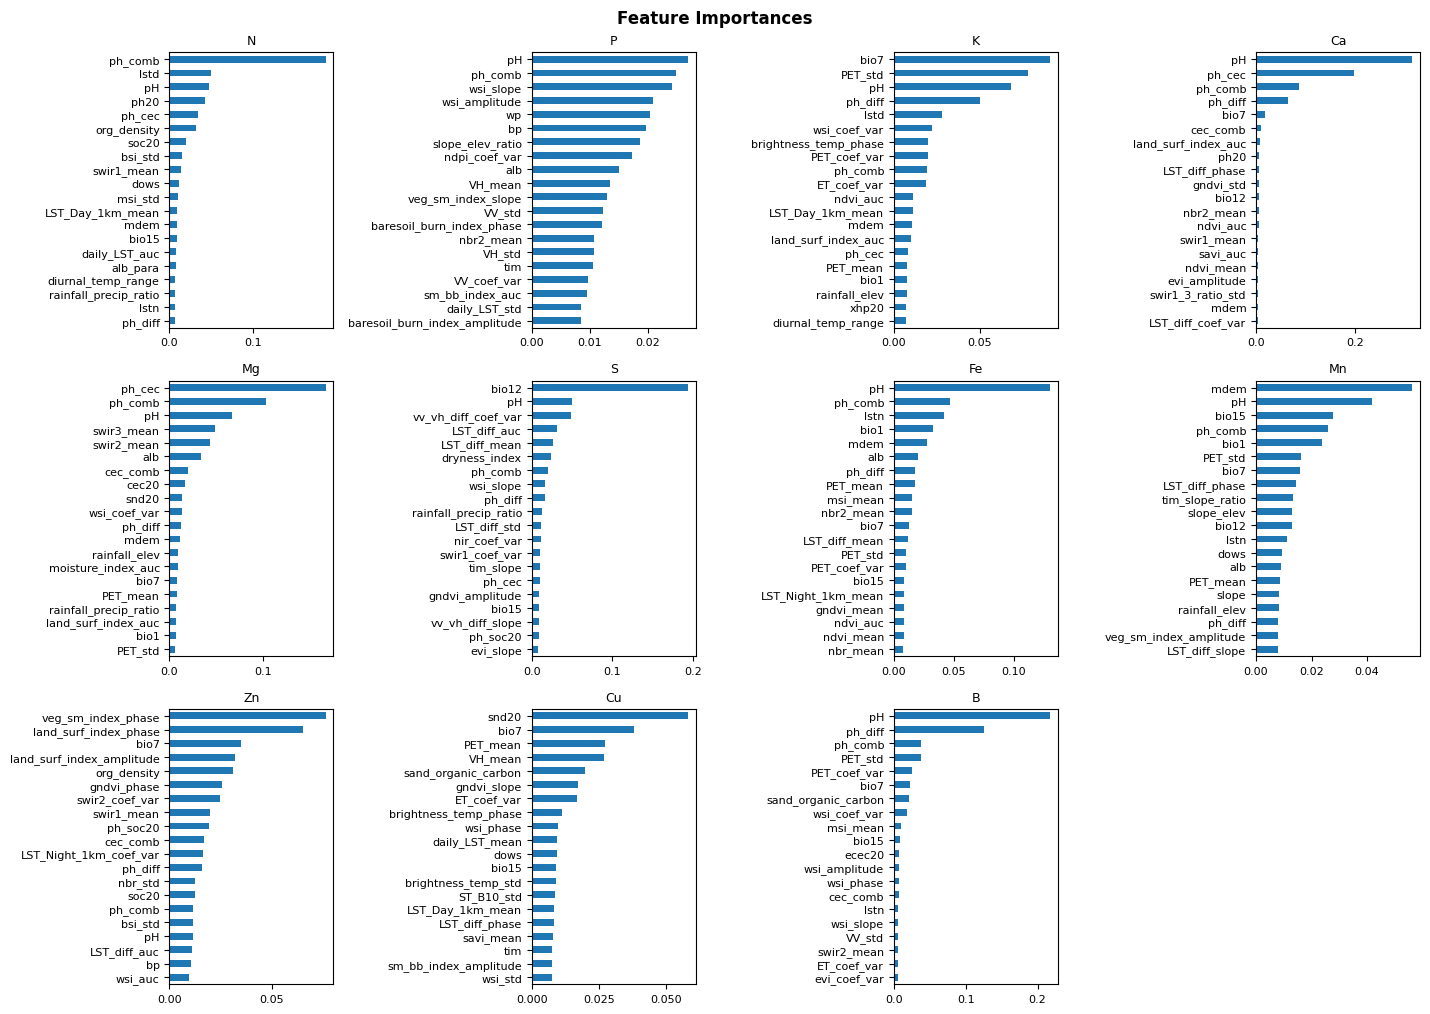

In [15]:
# plot feature importance
plot_feature_importance(rf_imp, 3, 4, topn=20, figsize=(14.4,10))

In [16]:
# saving predictions
save_file(rf_preds, 'random_forest_rmse_1066')

# saving feature importance
rf_imp.to_csv('random_forest_feature_importance.csv')